<a href="https://colab.research.google.com/github/raguram/eva/blob/master/S15/DataPreparation_ComputeStatistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount the drive

In [0]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Load the required modules

In [0]:
import sys

%rm -rf /content/eva
!git clone https://github.com/raguram/eva.git

sys.path.append("/content/eva/cnn-lib/src/cnnlib")
sys.path.append("/content/eva/cnn-lib/src/")
print("Added required libraries to system path")

Cloning into 'eva'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 830 (delta 71), reused 100 (delta 40), pack-reused 691
Receiving objects: 100% (830/830), 32.59 MiB | 23.27 MiB/s, done.
Resolving deltas: 100% (385/385), done.
Added required libraries to system path


## Unzip the data file

In [0]:
!rm -rf /content/data
import Utility 
Utility.unzip("/content/drive/My Drive/Colab Notebooks/workspace/data/Assignment15/tiny_data.zip", "/content/data")

uncompressed_size 371.686523


## Create Tiny data set for testing 

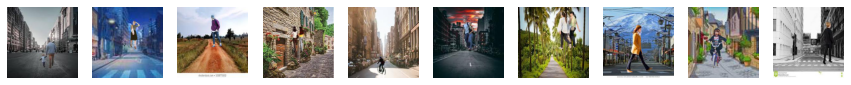

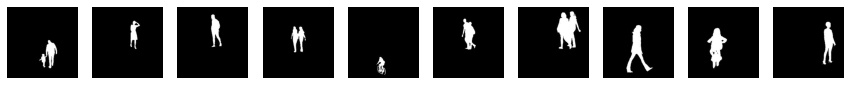

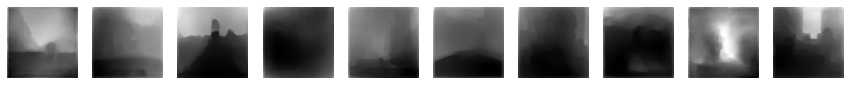

In [0]:
from os import listdir
import ImageUtils
from PIL import Image
from os.path import join
import numpy as np 
import ImageUtils
from ImageDao import ZipFileImagePersister
from zipfile import ZipFile

fg_bg = np.array(listdir("/content/fg_bg"))
fg_bg_mask = np.array(listdir("/content/fg_bg_mask"))
fg_bg_depth = np.array(listdir("/content/fg_bg_depth"))
bg = np.array(listdir("/content/bg_images"))
fg = np.array(listdir("/content/fg_images"))

r = np.random.choice(len(fg_bg), size=20000, replace=False)

bg_images = [Image.open(join("/content/bg_images", i)) for i in bg]
fg_images = [Image.open(join("/content/fg_images", i)) for i in fg]
fg_bg_tiny = [Image.open(join("/content/fg_bg", i)) for i in fg_bg[r]]
fg_bg_mask_tiny = [Image.open(join("/content/fg_bg_mask", i)) for i in fg_bg_mask[r]]
fg_bg_depth_tiny = [Image.open(join("/content/fg_bg_depth", i)) for i in fg_bg_depth[r]]

ImageUtils.show_images(fg_bg_tiny[:10])
ImageUtils.show_images(fg_bg_mask_tiny[:10])
ImageUtils.show_images(fg_bg_depth_tiny[:10])

zipf = ZipFile("tiny_data.zip", "a")
persister = ZipFileImagePersister(zipf, "fg_images", "png")(fg_images, fg)
persister = ZipFileImagePersister(zipf, "bg_images")(bg_images, bg)
persister = ZipFileImagePersister(zipf, "fg_bg")(fg_bg_tiny, fg_bg[r])
persister = ZipFileImagePersister(zipf, "fg_bg_mask")(fg_bg_mask_tiny, fg_bg_mask[r])
persister = ZipFileImagePersister(zipf, "fg_bg_depth")(fg_bg_depth_tiny, fg_bg_depth[r]) 
zipf.close()

In [0]:
!cp /content/tiny_data.zip /content/drive/My\ Drive/Colab\ Notebooks/workspace/data/Assignment15/

## Dataset utility


In [0]:
import torch.utils.data as data
import os
from os.path import join
from PIL import Image
from cnnlib import Utility
import re
from torchvision import transforms

def load_image(folder, file):
    return Image.open(join(folder, file))

class CustomImageDataset(data.Dataset):

    def __init__(self, input_folder):
        self.input_folder = input_folder
        self.image_files = os.listdir(input_folder)
        self.t = transforms.ToTensor() 

    def __getitem__(self, index):
        img = load_image(self.input_folder, self.image_files[index])
        return self.t(img)

    def __len__(self):
        return len(self.image_files)


In [0]:
import torch 
from tqdm import tqdm_notebook as tqdm
import numpy as np 

class Stats: 

  def __init__(self, dim, size, mean, std): 
    self.dim = dim
    self.size = size 
    self.mean = mean
    self.std = std

def compute_stats(image_folder): 

  dataset = CustomImageDataset(image_folder)
  loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=512, num_workers=2)

  pbar = tqdm(loader, ncols=1000)
  mean_sum = np.zeros(3)
  std_sum = np.zeros(3)
  for idx, images in enumerate(pbar):

    dim = images[0].shape
    mean = images.mean(dim=0).mean(1).mean(1)
    std = images.std(dim=0).std(1).std(1)
    mean_sum = np.add(mean_sum, mean)
    std_sum = np.add(std_sum, std)
  
  return Stats(dim, len(loader.dataset), mean_sum/len(loader), std_sum/len(loader))

## Compute Stats

In [0]:
stats = compute_stats("/content/data/bg_images")
print(stats.dim, stats.size, stats.mean, stats.std)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



torch.Size([3, 224, 224]) 110 tensor([0.4491, 0.4220, 0.3983], dtype=torch.float64) tensor([0.0056, 0.0045, 0.0048], dtype=torch.float64)


In [0]:
stats = compute_stats("/content/data/fg_bg")
print(stats.dim, stats.size, stats.mean, stats.std)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



torch.Size([3, 224, 224]) 20000 tensor([0.4390, 0.4121, 0.3918], dtype=torch.float64) tensor([0.0042, 0.0037, 0.0044], dtype=torch.float64)


In [0]:
stats = compute_stats("/content/data/fg_bg_mask")
print(stats.dim, stats.size, stats.mean, stats.std)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



torch.Size([1, 224, 224]) 20000 tensor([0.0847, 0.0847, 0.0847], dtype=torch.float64) tensor([0.0433, 0.0433, 0.0433], dtype=torch.float64)


In [0]:
stats = compute_stats("/content/data/fg_bg_depth")
print(stats.dim, stats.size, stats.mean, stats.std)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



torch.Size([1, 224, 224]) 20000 tensor([0.3870, 0.3870, 0.3870], dtype=torch.float64) tensor([0.0037, 0.0037, 0.0037], dtype=torch.float64)
